In [1]:
%load_ext autoreload
%autoreload 2

# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [3]:
import glob
from src.model.cnos_foundpose import cnos_foundpose, cnos_different_thresholds


dataset = "icbin"
obj_id = 1
rgb_paths = sorted(glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/test/{obj_id:06d}/rgb/*.png"))

[2024-10-19 19:14:20,950] [INFO] torch.distributed.nn.jit.instantiator: Created a temporary directory at /tmp/tmpa7u8bn72
[2024-10-19 19:14:20,952] [INFO] torch.distributed.nn.jit.instantiator: Writing /tmp/tmpa7u8bn72/_remote_module_non_scriptable.py
[2024-10-19 19:14:20,988] [INFO] faiss.loader: Loading faiss with AVX512 support.
[2024-10-19 19:14:21,047] [INFO] faiss.loader: Successfully loaded faiss with AVX512 support.


In [4]:
# i = 2
# scene_id = int(rgb_paths[i].split("/")[-3])
# frame_id = int(rgb_paths[i].split("/")[-1].split(".")[0])
# cnos_foundpose(rgb_path=rgb_paths[i], scene_id=scene_id, frame_id=frame_id, obj_id=obj_id, dataset=dataset)

In [5]:
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam

def _move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)

model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) 

_move_to_device(custom_sam_model)

[2024-10-19 19:15:07,584] [INFO] root: Loading SAM model from datasets/bop23_challenge/pretrained/segment-anything
[2024-10-19 19:15:11,585] [INFO] root: Init CustomSamAutomaticMaskGenerator done!


In [ ]:
from tqdm import trange

for i in range(len(rgb_paths)):
# for i in trange(0,30):
    scene_id = int(rgb_paths[i].split("/")[-3])
    frame_id = int(rgb_paths[i].split("/")[-1].split(".")[0])
    cnos_different_thresholds(rgb_path=rgb_paths[i], custom_sam_model=custom_sam_model, scene_id=scene_id, frame_id=frame_id, obj_id=obj_id, dataset=dataset)

# Test on single crops

datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000000.png


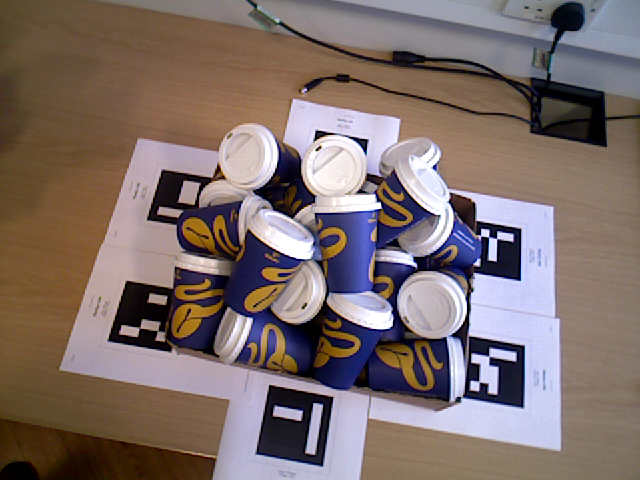

In [9]:
import glob
from src.model.cnos_foundpose import foundpose
from PIL import Image

idx  = 0
print(rgb_paths[idx])
Image.open(rgb_paths[idx])

In [12]:
scene_id = int(rgb_paths[idx].split("/")[-3])
frame_id = int(rgb_paths[idx].split("/")[-1].split(".")[0])
score_dict = foundpose(rgb_path=rgb_paths[idx], custom_sam_model=custom_sam_model, scene_id=scene_id, frame_id=frame_id, obj_id=obj_id, dataset=dataset)

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
[2024-09-04 23:26:24,180] [INFO] dinov2: using MLP layer as FFN
/home/cuong.van-dam/CuongVanDam/do_an_tot_nghiep/cnos/src/model/constrastive_learning.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_image = F.interpolate(torch.tensor(image).unsqueeze(0), scale_factor=scale_factor.item())[0] # unsqueeze at  0 - B,C, H, W
  0%|          | 0/103 [00:00<?, ?it/s]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.24 s, search 0.21 s): objective=9.73319e+07 imbalance=1.123 nsplit=0       


  1%|          | 1/103 [00:03<05:37,  3.31s/it]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.26 s, search 0.21 s): objective=9.73315e+07 imbalance=1.123 nsplit=0       


  2%|▏         | 2/103 [00:07<06:14,  3.71s/it]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.28 s, search 0.21 s): objective=9.72873e+07 imbalance=1.123 nsplit=0       


  3%|▎         | 3/103 [00:10<06:09,  3.69s/it]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.26 s, search 0.21 s): objective=9.73612e+07 imbalance=1.124 nsplit=0       


  4%|▍         | 4/103 [00:14<05:54,  3.58s/it]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.27 s, search 0.21 s): objective=9.73788e+07 imbalance=1.125 nsplit=0       


  5%|▍         | 5/103 [00:17<05:49,  3.56s/it]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.26 s, search 0.20 s): objective=9.73461e+07 imbalance=1.125 nsplit=0       


  6%|▌         | 6/103 [00:21<05:41,  3.52s/it]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.28 s, search 0.21 s): objective=9.74136e+07 imbalance=1.125 nsplit=0       


  7%|▋         | 7/103 [00:24<05:34,  3.48s/it]WARNING clustering 78366 points to 2048 centroids: please provide at least 79872 training points


Clustering 78366 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.29 s, search 0.20 s): objective=9.73759e+07 imbalance=1.122 nsplit=0       


  8%|▊         | 8/103 [00:28<05:40,  3.58s/it]


KeyboardInterrupt: 